In [1]:
from math import log
import random
import numpy as np
import cvxpy as cp
from math import sqrt

In [2]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

plt.rcParams['font.size'] = 14.0
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams.update({'mathtext.default': 'regular' })

In [3]:
def T(x, tau):
    return np.sign(x) * np.maximum(np.abs(x) - tau, 0.0)

In [4]:
def sgn(x):
    return np.where(x < 0, -1, 1)

In [5]:
def create_sparse_vector(n, s):
    x = np.zeros(n)  # Initialize zero vector
    indices = np.random.permutation(n)[:s]  # Randomly select s indices
    x[indices] = np.random.randn(s)  # Assign random values at selected indices

    return x

In [6]:
def H(x, A, b, lambd):
    return np.linalg.norm(A @ x - b, 1) + lambd * np.linalg.norm(x, 1)

In [7]:
def CVX(A, b, c, lambd):
    
    x = cp.Variable(n)
    
    prob = cp.Problem(
        cp.Minimize(
            cp.norm1(A @ x - b) + lambd * cp.norm1(x)
        )
    )
    
    prob.solve()
    
    return x.value, prob.value

In [8]:
def grad_h(x, A, b, mu):
    z = A @ x - b
    return (1/mu) * A.T @ (z - T(z, mu))

In [9]:
def subgrad_H(x, A, b, lambd):
    return A.T @ sgn(A @ x - b) + lambd * sgn(x)

In [10]:
def grad_H(x, A, b, mu, mu_tilde, lambd):
    z = A @ x - b
    return (1/mu) * A.T @ (z - T(z, mu)) + (lambd / mu_tilde) * (x - T(x, mu_tilde))

In [11]:
def subgrad(A, b, stepsize, H_opt, c=None, max_k=None):
    
    x = np.zeros(n)
    
    k = 1
    t = 1
    H_curr = H(x, A, b, lambd)  
    
    differences = []
    
    if max_k:
    
        while k <= max_k:
            
            g = subgrad_H(x, A, b, lambd)
            
            if stepsize == 'dynamic':
                t = 1 / (np.linalg.norm(g) * sqrt(k+1))
            if stepsize == 'polyak':
                t = (H(x, A, b, lambd) - H_opt) / np.linalg.norm(g)**2
            
            x = x - t * g
            
            k += 1
            
            H_curr = H(x, A, b, lambd)
            
            differences.append(H_curr - H_opt)
            
        return differences

    while H_curr >= c * H_opt:
            
        g = subgrad_H(x, A, b, lambd)

        if stepsize == 'dynamic':
            t = 1 / (np.linalg.norm(g) * sqrt(k+1))
        if stepsize == 'polyak':
            t = (H(x, A, b, lambd) - H_opt) / np.linalg.norm(g)**2

        x = x - t * g
        
        k += 1

        H_curr = H(x, A, b, lambd)

        differences.append(H_curr - H_opt)
        
    return differences

In [12]:
def s_fista_classic(A, b, epsilon, n, lambd, H_opt, c=None, max_k=None):
    
    mu = epsilon / n
    L_tilde = max(np.linalg.svdvals(A)) / mu
    
    k = 1
    
    x = np.zeros(n)
    y = np.zeros(n)
    
    t = 1
    
    differences = []
    
    H_curr = H(x, A, b, lambd)
    
    if max_k:
        
        while k <= max_k:

            nabla_h = grad_h(y, A, b, mu)
            x_old = x
            x = T(y - (1/L_tilde) * nabla_h, lambd / L_tilde)

            t_old = t
            t = (1 + sqrt(1 + 4 * t**2)) / 2

            y = x + ((t - 1) / t_old) * (x - x_old)

            differences.append(
                H(x, A, b, lambd) - H_opt
            )

            k += 1
        
        return differences

    while H_curr >= c * H_opt:
        
        nabla_h = grad_h(y, A, b, mu)
        x_old = x
        x = T(y - (1/L_tilde) * nabla_h, lambd / L_tilde)
        
        t_old = t
        t = (1 + sqrt(1 + 4 * t**2)) / 2
        
        y = x + ((t - 1) / t_old) * (x - x_old)
        
        H_curr = H(x, A, b, lambd)
        
        differences.append(
            H_curr - H_opt
        )
        
        k += 1
        
    return differences

In [13]:
def s_fista_no_prox(A, b, epsilon, n, lambd, H_opt, c=None, max_k=None):
    
    mu = epsilon / n
    mu_tilde = epsilon / (lambd * n)
    L_s = max(np.linalg.svdvals(A)) / mu + lambd/mu_tilde
    
    k = 1
    
    x = np.zeros(n)
    y = np.zeros(n)
    
    t = 1
    
    differences = []
    
    H_curr = H(x, A, b, lambd)
    
    if max_k:
        
        while k <= max_k:
            
            nabla_H = grad_H(y, A, b, mu, mu_tilde, lambd)
            x_old = x
            x = y - (1/L_s) * nabla_H

            t_old = t
            t = (1 + sqrt(1 + 4 * t**2)) / 2

            y = x + ((t - 1) / t_old) * (x - x_old)

            H_curr = H(x, A, b, lambd)

            differences.append(
                H_curr - H_opt
            )

            k += 1
        
        return differences

    while H_curr >= c * H_opt:
        
        nabla_H = grad_H(y, A, b, mu, mu_tilde, lambd)
        x_old = x
        x = y - (1/L_s) * nabla_H
        
        t_old = t
        t = (1 + sqrt(1 + 4 * t**2)) / 2
        
        y = x + ((t - 1) / t_old) * (x - x_old)
        
        H_curr = H(x, A, b, lambd)
        
        differences.append(
            H_curr - H_opt
        )
        
        k += 1
        
    return differences

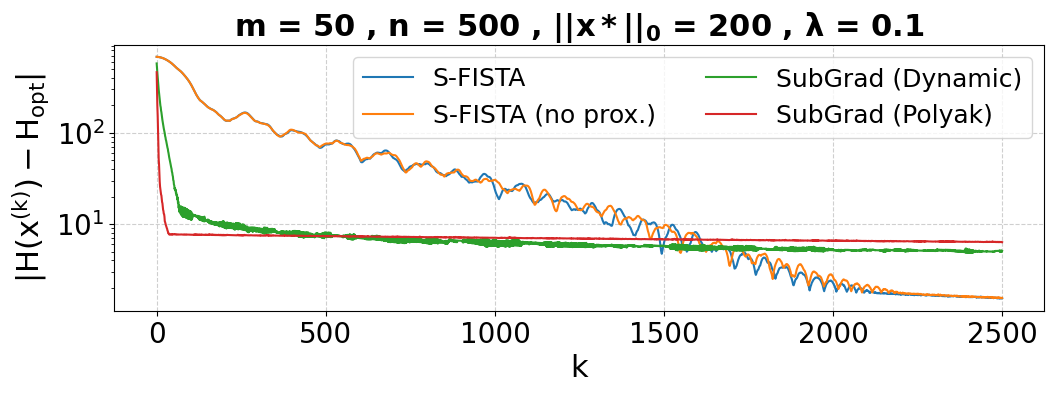

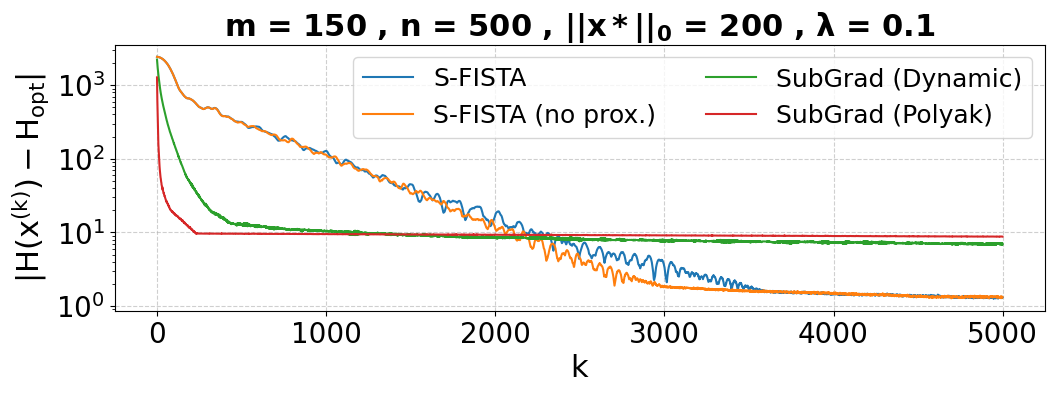

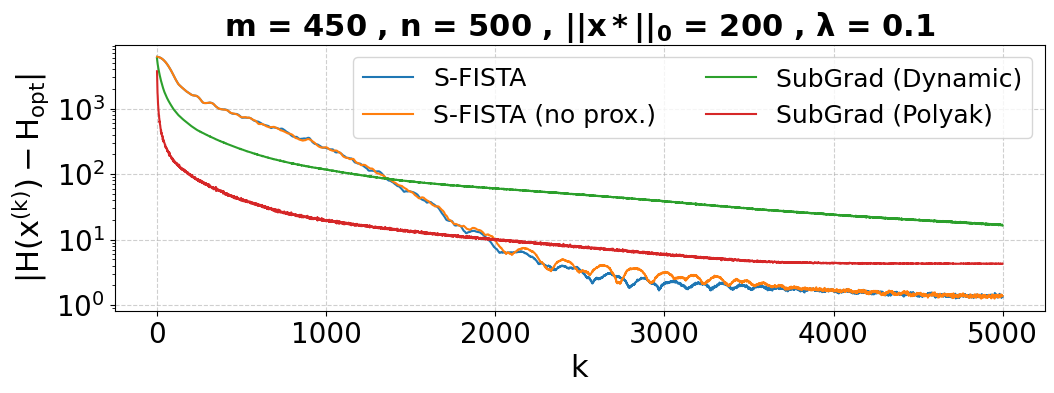

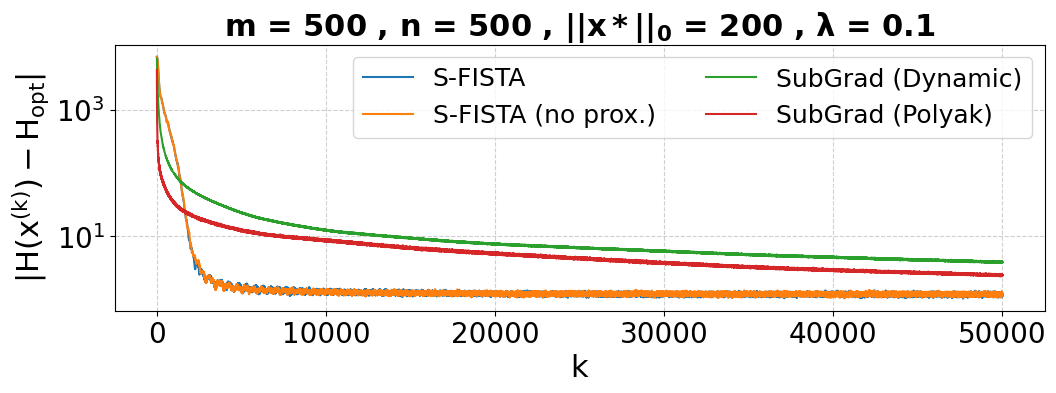

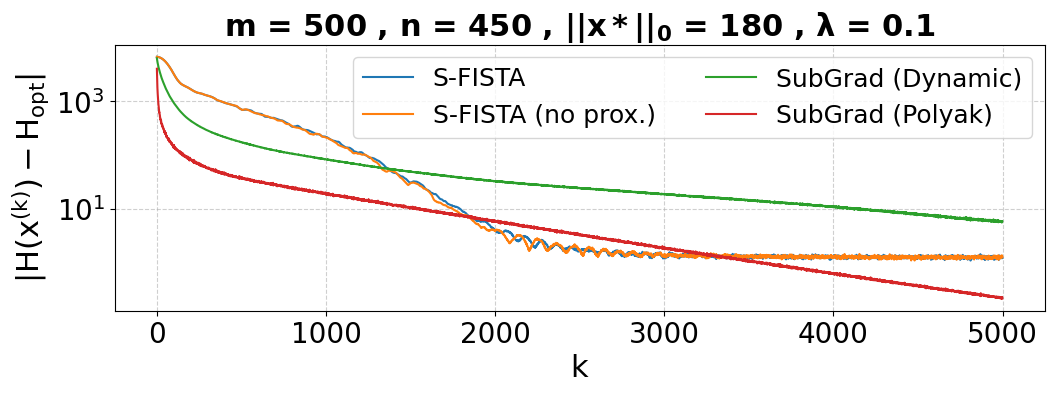

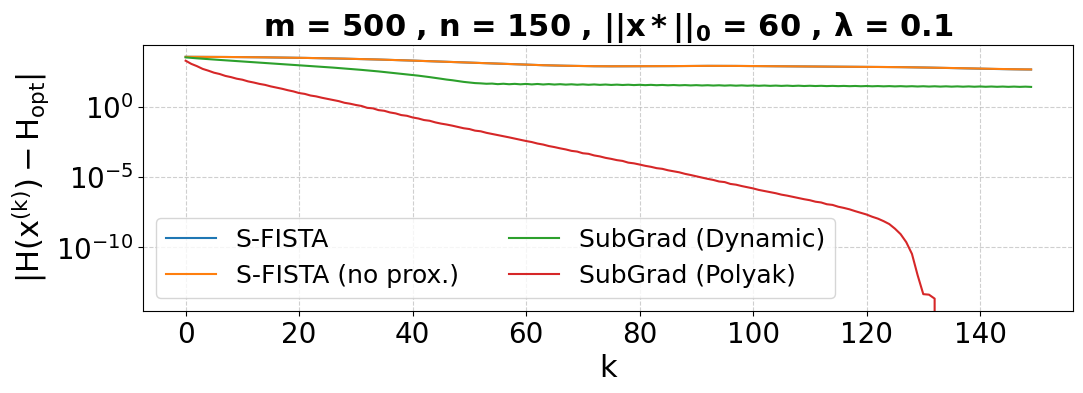

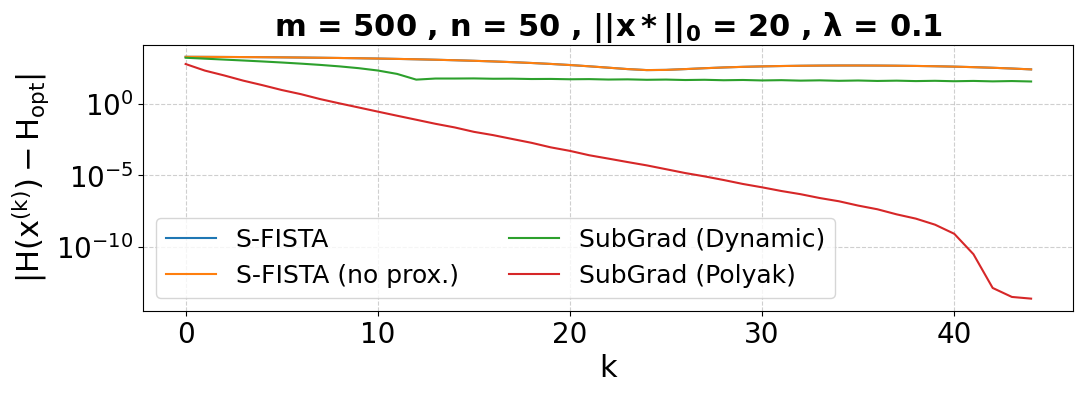

In [35]:
lambd = 0.1
sparcity_percentage = 0.4

epsilon_sfista = 0.1
c=None

for m, n, max_k in [(50, 500, 2500), (150, 500, 5000), (450, 500, 5000), (500, 500, 50000), (500, 450, 5000), (500, 150, 150), (500, 50, 45)]:
#for m, n, max_k in [(50, 500, 2500)]:

    
    np.random.seed(44)
    random.seed(44)

    A = np.random.randn(m, n)
    c = np.random.rand(n)

    r = int((1 - sparcity_percentage) * n)
    x_sol = create_sparse_vector(n, r)

    b = A @ x_sol

    x_cvx, H_cvx = CVX(A, b, c, lambd)
    
    diffs_sfista_classic = s_fista_classic(A, b, epsilon_sfista, n, lambd, H_cvx, c=c, max_k=max_k)
    k_sfista_classic = [i for i in range(len(diffs_sfista_classic))]
    
    diffs_sfista_noprox = s_fista_no_prox(A, b, epsilon_sfista, n, lambd, H_cvx, c=c, max_k=max_k)
    k_sfista_noprox = [i for i in range(len(diffs_sfista_noprox))]
    
    diffs_subgrad_dynamic = subgrad(A, b, 'dynamic', H_cvx, c=c, max_k=max_k)
    k_subgrad_dynamic = [i for i in range(len(diffs_subgrad_dynamic))]
    
    diffs_subgrad_polyak = subgrad(A, b, 'polyak', H_cvx, c=c, max_k=max_k)
    k_subgrad_polyak = [i for i in range(len(diffs_subgrad_polyak))]
    

    pdf = PdfPages(f'plots/2.6_ALL_{m}_{n}.pdf')
    plt.figure(figsize=(12, 3.8))
    
    plt.plot(k_sfista_classic, diffs_sfista_classic, label=f'S-FISTA')
    plt.plot(k_sfista_noprox, diffs_sfista_noprox, label=f'S-FISTA (no prox.)')
    plt.plot(k_subgrad_dynamic, diffs_subgrad_dynamic, label=f'SubGrad (Dynamic)')
    plt.plot(k_subgrad_polyak, diffs_subgrad_polyak, label=f'SubGrad (Polyak)')

    # Add grid
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.legend(ncols=2)

    # Label the axes
    plt.xlabel('$k$')
    plt.ylabel('$|H(x^{(k)}) - H_{opt}|$')

    #plt.xscale('log')
    plt.yscale('log')

    plt.title(f"m = {m} , n = {n} , $||x*||_0$ = {n-r} , λ = {lambd}")

    plt.subplots_adjust(bottom=0.2, top=0.9)

    pdf.savefig(plt.gcf()) # Save the current figure
    plt.show()
    plt.close()
    pdf.close()